In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

# Introduction

## Background

We want to know whether certain events give impact to search queries of one Indonesia's e-commerce giant: Bukalapak. On 2017's Chinese New Year, Bukalapak created ads with Bu Linda as main character on their "Nego Cincai" campaign. Does it affect its search queries? Since we don't know what would happen if that incident didn't happen, we'll estimate it using time series hypothesis test techniques.

## Research Questions

Does Nego Cincai campaign affect Bukalapak's Google search queries?

# Assumptions and Known Limitations

...

# Data Preparation

We retrieve search queries count of Bukalapak from [Google Trend](https://trends.google.com/trends/explore?date=all&geo=ID&q=%2Fg%2F121v7wz6,%2Fm%2F0114n4dz).

In [2]:
df_sq = pd.read_csv("/media/elvyna/DATA/data-analysis/jupyter-notebook/dataset/20180915-google-trend-tokopedia-bukalapak.csv")

df_sq['Month'] = pd.to_datetime(df_sq['Month'])
df_sq.drop(labels=['Tokopedia'], axis=1, inplace=True)

In [3]:
print("Preview - search query data")
print("===========================")
df_sq.head()

Preview - search query data


,Month,Bukalapak
0,2011-01-01,4
1,2011-02-01,4
2,2011-03-01,4
3,2011-04-01,5
4,2011-05-01,4


# Analysis

Before we go further, let's check out the query growth!

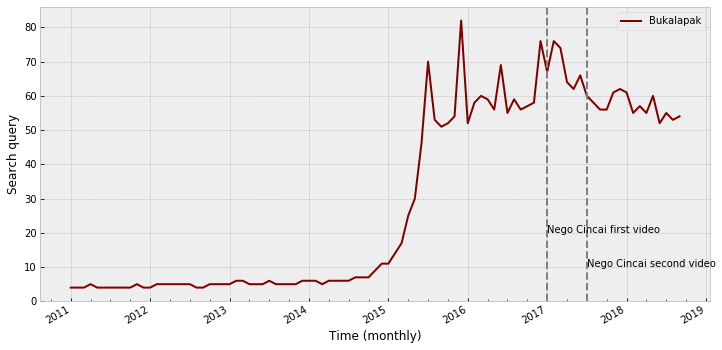

In [4]:
import matplotlib.dates as mdates

f, ax = plt.subplots(figsize=(12,6))

df_sq.plot(
        kind='line',
        x='Month',
        y='Bukalapak',
        ax=ax,
        label='Bukalapak',
        color='maroon'
    )

ax.format_xdata =  mdates.DateFormatter('%Y-%m-%d')
plt.xlabel("Time (monthly)")
plt.ylabel("Search query")
f.autofmt_xdate()


ax.axvline(
    x='2017-01-25',
    ymin=0,
    ymax=100,
    linestyle='dashed',
    color='grey'
)

ax.annotate(
    xy=('2017-01-25',20),
    s='Nego Cincai first video'
)

ax.axvline(
    x='2017-07-23',
    ymin=0,
    ymax=100,
    linestyle='dashed',
    color='grey'
)

ax.annotate(
    xy=('2017-07-23',10),
    s='Nego Cincai second video'
)

plt.show()

Note:

- Based on the videos' published date, Nego Cincai campaign started on January 25, 2017; with following short drama which introduced Bu Linda on January 26, 2017. There is also another ads featuring Bu Linda on July 23, 2017.

Bukalapak has increasing queries around mid 2015. We observe **multiplicative model** here, since effect of seasonality and variations increase as level of the trend rises. We will decompose the data into trend and seasonal components; then we'll subtract the original data with its trend and seasonality to get the residuals.

Time series decomposition - Bukalapak


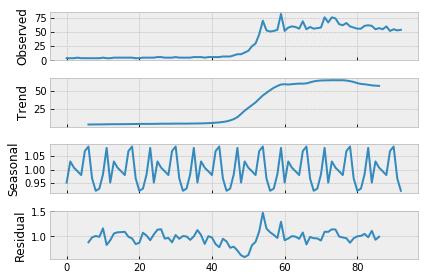

In [5]:
# freq = 12; look for yearly seasonality

from statsmodels.tsa.seasonal import seasonal_decompose
res_bl = seasonal_decompose(df_sq['Bukalapak'], freq=12, model='multiplicative')

print("Time series decomposition - Bukalapak")
res_bl.plot()
plt.show()

## Hypothesis Testing



In [6]:
df_sq = df_sq.merge(
    pd.DataFrame(res_bl.resid),
    how='left',
    left_index=True,
    right_index=True
).rename(columns={'Bukalapak_x':'observed',
                 'Bukalapak_y':'residual'})

In [7]:
START_VIDEO_1 = pd.to_datetime('2017-01-25')
START_VIDEO_2 = pd.to_datetime('2017-07-23')

def check_flag(df, dt_column='Month'):
    _flag = []
    for ix, row in df.iterrows():
        if row[dt_column] < START_VIDEO_1:
            _flag.append('BEFORE_CAMPAIGN')
        elif row[dt_column] < START_VIDEO_2:
            _flag.append('AFTER_FIRST_CAMPAIGN')
        else:
            _flag.append('AFTER_SECOND_CAMPAIGN')
    return _flag

In [8]:
df_sq['flag'] = check_flag(df_sq)

### Hypothesis 1

> - H0: First campaign doesn't affect the search query.
> - H1: First campaign changes number of search query.

Since we already extract the residuals, we assume that search query before and after first campaign are independent.

In [9]:
np.var(df_sq[(df_sq['flag'] == 'BEFORE_CAMPAIGN')]['residual'])

0.020413900521461633

In [10]:
np.var(df_sq[(df_sq['flag'] != 'BEFORE_CAMPAIGN')]['residual'])

0.005496942695240381

In [11]:
from scipy.stats import ttest_ind

ttest_ind(
    a=df_sq[(df_sq['flag'] == 'BEFORE_CAMPAIGN')]['residual'],
    b=df_sq[(df_sq['flag'] != 'BEFORE_CAMPAIGN')]['residual'],
    nan_policy='omit'
)

Ttest_indResult(statistic=-1.0006137627915768, pvalue=0.3200686506120875)

The first campaign doesn't significantly change number of search query.

In [12]:
from scipy.stats import ttest_ind

ttest_ind(
    a=df_sq[(df_sq['flag'] == 'AFTER_SECOND_CAMPAIGN')]['residual'],
    b=df_sq[(df_sq['flag'] != 'AFTER_SECOND_CAMPAIGN')]['residual'],
    nan_policy='omit'
)

Ttest_indResult(statistic=0.6360862248994579, pvalue=0.5265588018756069)

The second campaign also doesn't significantly change number of search query.

## Causal Impact

In [20]:
df_sq.to_csv("/media/elvyna/DATA/data-analysis/jupyter-notebook/dataset/20180916-bukalapak-campaign.csv",
            index=False)

In [21]:
# from causal_impact.causal_impact import CausalImpact

# # df_sq.index = df_sq.Month
# # ci = CausalImpact(data=df_sq['observed'],
# #             inter_date=pd.to_datetime(START_VIDEO_1.to_period('M').start_time,
# #                                       format='%Y-%m-%d'))

# ci = CausalImpact(data=df_sq['observed'],
#             inter_date=73)

In [22]:
# ci.run()
# ci.plot()

# Results and Discussions

*describe what you find and how it can be improved*

# References

